In [1]:
from hcipy import *
import numpy as np
import poke.poke_core as pol
import poke.plotting as plot
from astropy.io import fits
import astropy.units as u
import poppy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# load jones pupil
pth = 'Subaru_M1-M3_750nm.fits'
jones_pupil = fits.open(pth)[0].data

# load scexao pupil
pupil_pth = 'scexao_pupil.fits'
pupil_data = fits.open(pupil_pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1]
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1] 

J11 *= pupil_data
J12 *= pupil_data
J21 *= pupil_data
J22 *= pupil_data

<ipython-input-3-573e4f499af1>:2: RuntimeWarning: invalid value encountered in true_divide
  plot.PlotJonesArray(J11*E[0]/pupil_data,J12*E[1]/pupil_data,J21*E[0]/pupil_data,J22*E[1]/pupil_data)


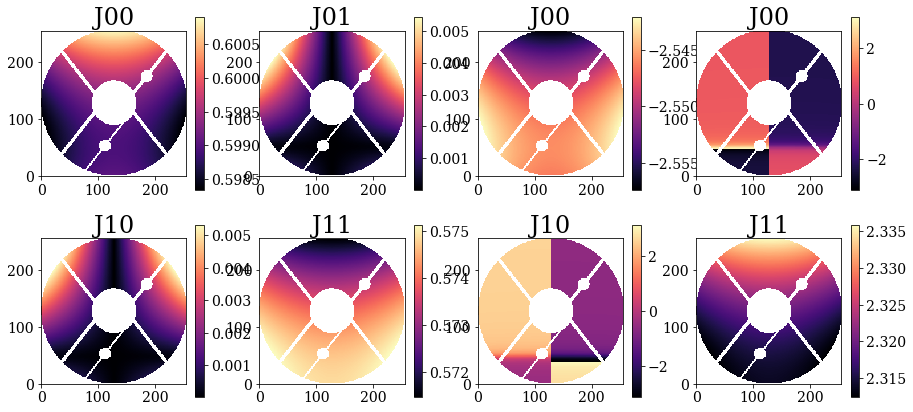

In [3]:
E = np.array([1,1j])/np.sqrt(2)
plot.PlotJonesArray(J11*E[0]/pupil_data,J12*E[1]/pupil_data,J21*E[0]/pupil_data,J22*E[1]/pupil_data)

In [4]:
pupil_grid = make_pupil_grid(256)
focal_grid = make_focal_grid(4, 20)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

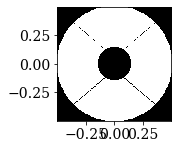

In [5]:
# aperture = J11*pupil_data # make_magellan_aperture(True)
# telescope_pupil = J11*pupil_data# aperture(pupil_grid)
aperture = make_magellan_aperture(True)
telescope_pupil = aperture(pupil_grid)
imshow_field(telescope_pupil, cmap='gray')
plt.show()

(256, 256)


<ipython-input-6-a277f1f6a564>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(wavefront.amplitude.shaped/pupil_data)
<ipython-input-6-a277f1f6a564>:27: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(fully_polarized_wavefront.amplitude.shaped/pupil_data)


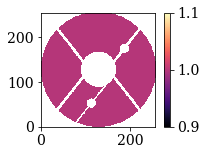

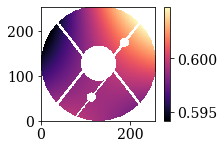

In [6]:
# Try a polarized wavefront
# jones = Field([[J11.ravel() , J12.ravel()],[J21.ravel() , J22.ravel()]], pupil_grid) # Circular Light Incident
E = [1,1j]/np.sqrt(2)

field_array = J11*E[0] + J12*E[1]

field_array_amp = np.abs(field_array)
field_array_ang = np.angle(field_array)

pupil_data = np.array(pupil_data,dtype=bool)

field_array_ang[pupil_data] -= np.mean(field_array_ang[pupil_data])
field_array = field_array_amp*np.exp(1j*field_array_ang)
print(field_array.shape)

jones = Field(field_array.ravel(), pupil_grid) # Circular Light Incident
scalar = Field(pupil_data.ravel(), pupil_grid)

wavefront = Wavefront(scalar)
fully_polarized_wavefront = Wavefront(jones)

plt.figure()
plt.imshow(wavefront.amplitude.shaped/pupil_data)
plt.colorbar()

plt.figure()
plt.imshow(fully_polarized_wavefront.amplitude.shaped/pupil_data)
plt.colorbar()

# imshow_field(fully_polarized_wavefront.amplitude)


# Optimization Parameters

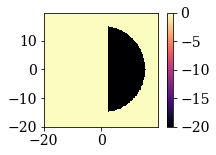

In [7]:
contrast_level = 1e-20

dark_zone = (circular_aperture(30)(focal_grid)).astype(bool)*(focal_grid.x>2)

contrast = focal_grid.ones()

contrast[dark_zone] = contrast_level

imshow_field(np.log10(contrast))
plt.colorbar()
plt.show()

In [8]:
def plot_vapp(vAPP, prop, niter):
    '''Plot the phase pattern and PSF of a vAPP

    Parameters
    ---------
    vAPP : Wavefront
        The wavefront of a vAPP mask, containing the vAPP pattern as phase and
        the telescope pupil as amplitude
    prop : Function
        A propagator function that propagates the wavefront to a focal plane
    '''

    # Plotting the phase pattern and the PSF
    fig = plt.figure(figsize=[10,5])
    plt.suptitle('num iterations = {}'.format(niter))
    ax1 = fig.add_subplot(121)
    im1 = imshow_field(vAPP.phase, mask=vAPP.amplitude, cmap='RdBu')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(122)
    im2 = imshow_field(np.log10(prop(vAPP).intensity/np.max(prop(vAPP).intensity)),vmin = -8, cmap='inferno')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.show()
    

In [9]:
# Setting up the vAPP calculation parameters.
num_iterations = 1000

# pupil_grid_max = make_pupil_grid(256)
# focal_grid_max = make_focal_grid(1, 1)
# prop_max = FraunhoferPropagator(pupil_grid_max, focal_grid_max)

In [10]:
# Generate the vAPP pattern.
vAPP = generate_app_keller(fully_polarized_wavefront, prop, contrast, num_iterations, beta = 1)
# ! pip install gurobipy
# vAPP = generate_app_por(fully_polarized_wavefront, prop, prop_max, contrast, num_iterations=num_iterations)

In [11]:
# Generate the vAPP pattern.
vAPP_scalar = generate_app_keller(wavefront, prop, contrast, num_iterations, beta = 1)
# vAPP_scalar = generate_app_por(wavefront, prop, prop, contrast, num_iterations)

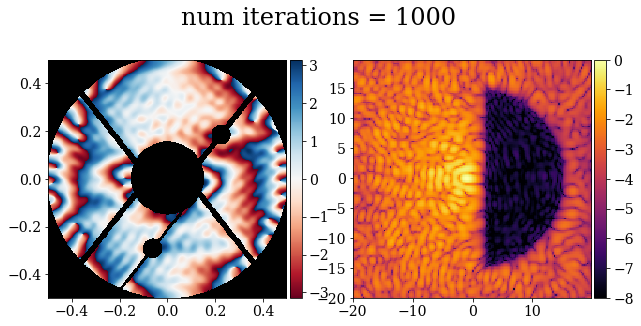

In [12]:
plot_vapp(vAPP, prop, num_iterations)

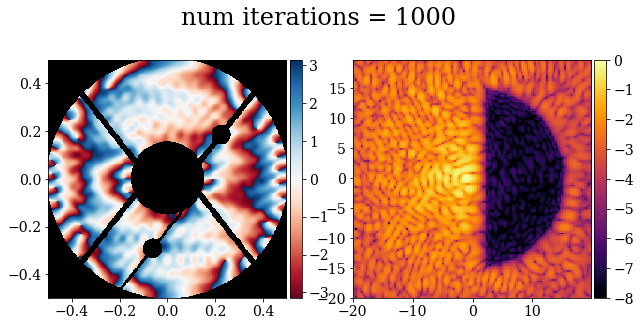

In [13]:
plot_vapp(vAPP_scalar, prop, num_iterations)

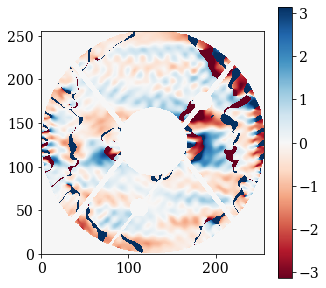

In [14]:
plt.figure(figsize=[5,5])
plt.imshow(vAPP.phase.shaped-vAPP_scalar.phase.shaped,cmap='RdBu',vmin=-np.pi,vmax=np.pi)
plt.colorbar()
plt.show()

In [15]:
# Want a plot propagating to focus assuming one wavefront or another
# Case: Assume scalar, propagate through polarized vAPP
scalar_wavefront = Wavefront(Field(pupil_data.ravel(),pupil_grid))

vAPPOptic = PhaseApodizer(vAPP.phase)
vAPPOptic_scalar = PhaseApodizer(vAPP_scalar.phase)

img = prop(vAPPOptic(scalar_wavefront))
img_scalar = prop(vAPPOptic_scalar(scalar_wavefront))


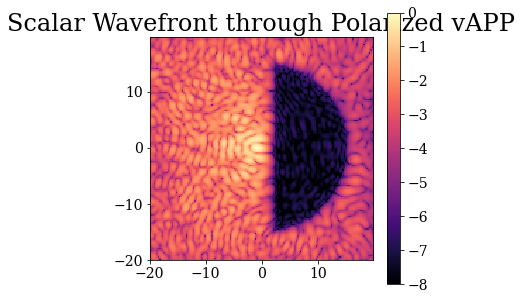

In [16]:
plt.figure(figsize=[5,5])
plt.title('Scalar Wavefront through Polarized vAPP')
imshow_field(np.log10(img.intensity/np.max(img.intensity)),vmin = -8, cmap='magma')
plt.colorbar()
plt.show()

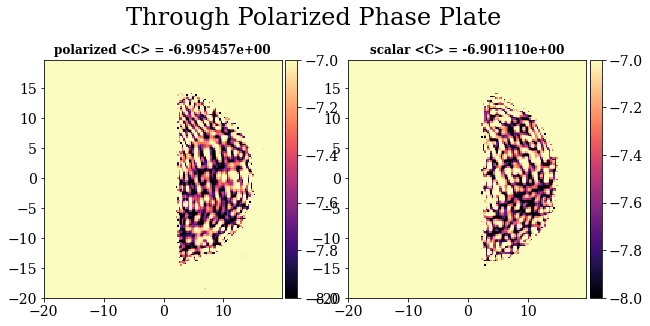

In [17]:
# Plotting the phase pattern and the PSF
fig = plt.figure(figsize=[10,5])
plt.suptitle('Through Polarized Phase Plate')

pol_avg = np.log10(np.mean(img.intensity[dark_zone]/np.max(img.intensity)))
sca_avg = np.log10(np.mean(img_scalar.intensity[dark_zone]/np.max(img_scalar.intensity)))

ax1 = fig.add_subplot(121)
ax1.set_title('polarized <C> = {:2e}'.format(pol_avg),fontsize=12,fontweight='bold')
im1 = imshow_field(np.log10(img.intensity/np.max(img.intensity)), cmap='magma',vmin=-8,vmax=-7)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('scalar <C> = {:2e}'.format(sca_avg),fontsize=12,fontweight='bold')
im2 = imshow_field(np.log10(img_scalar.intensity/np.max(img_scalar.intensity)), cmap='magma',vmin=-8,vmax=-7)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
plt.subplots_adjust()
plt.show()
    

In [18]:
# Want a plot propagating to focus assuming one wavefront or another
# Case: Assume polarized, propagate through scalar vAPP
polar_wavefront = Wavefront(jones)

img_frompol = prop(vAPPOptic(polar_wavefront))
img_scalar_frompol = prop(vAPPOptic_scalar(polar_wavefront))

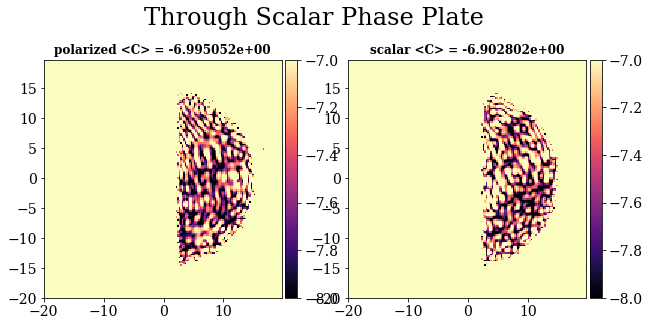

In [19]:
# Plotting the phase pattern and the PSF
fig = plt.figure(figsize=[10,5])
plt.suptitle('Through Scalar Phase Plate')

pol_avg = np.log10(np.mean(img_frompol.intensity[dark_zone]/np.max(img_frompol.intensity)))
sca_avg = np.log10(np.mean(img_scalar_frompol.intensity[dark_zone]/np.max(img_scalar_frompol.intensity)))

ax1 = fig.add_subplot(121)
ax1.set_title('polarized <C> = {:2e}'.format(pol_avg),fontsize=12,fontweight='bold')
im1 = imshow_field(np.log10(img_frompol.intensity/np.max(img_frompol.intensity)), cmap='magma',vmin=-8,vmax=-7)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('scalar <C> = {:2e}'.format(sca_avg),fontsize=12,fontweight='bold')
im2 = imshow_field(np.log10(img_scalar_frompol.intensity/np.max(img_scalar_frompol.intensity)), cmap='magma',vmin=-8,vmax=-7)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
plt.show()

<ipython-input-20-58ebe9f33691>:7: RuntimeWarning: divide by zero encountered in log10
  im1 = imshow_field(np.log10(np.abs(img_frompol.intensity/np.max(img_frompol.intensity)-img.intensity/np.max(img.intensity))), cmap='RdBu',vmin=-10,vmax=-9)
<ipython-input-20-58ebe9f33691>:15: RuntimeWarning: divide by zero encountered in log10
  im2 = imshow_field(np.log10(np.abs(img_scalar_frompol.intensity/np.max(img_scalar_frompol.intensity)-img_scalar.intensity/np.max(img_scalar.intensity))), cmap='RdBu',vmin=-10,vmax=-9)


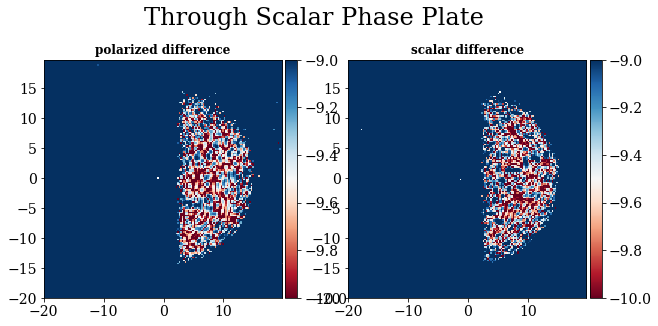

In [20]:
# Now the difference
fig = plt.figure(figsize=[10,5])
plt.suptitle('Through Scalar Phase Plate')

ax1 = fig.add_subplot(121)
ax1.set_title('polarized difference',fontsize=12,fontweight='bold')
im1 = imshow_field(np.log10(np.abs(img_frompol.intensity/np.max(img_frompol.intensity)-img.intensity/np.max(img.intensity))), cmap='RdBu',vmin=-10,vmax=-9)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('scalar difference',fontsize=12,fontweight='bold')
im2 = imshow_field(np.log10(np.abs(img_scalar_frompol.intensity/np.max(img_scalar_frompol.intensity)-img_scalar.intensity/np.max(img_scalar.intensity))), cmap='RdBu',vmin=-10,vmax=-9)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
plt.show()

# Try inject an off-axis PSF into the polarized one

In [45]:
# Polarized Optic vAPP

j11_wav = Wavefront(jones)
angular_separation = 9

j11_psf_ofax = Wavefront(jones * np.exp(2j*np.pi * pupil_grid.x * angular_separation))
j11_psf_ofax.total_power = 1e-5

science_image = prop(vAPPOptic(j11_wav)).intensity + prop(vAPPOptic(j11_psf_ofax)).intensity


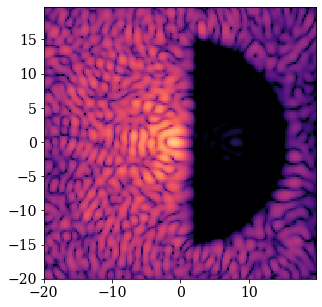

In [47]:
plt.figure(figsize=[5,5])
imshow_field(np.log10(science_image), cmap='magma',vmin=-7,vmax=-1)
plt.show()